In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord

# this will require installing gala, see here: http://gala.adrian.pw/en/latest/index.html
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [4]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields)
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]

ind_lmc = subhalos_z0['pid']==LMC_analog['id']

#Reading in data from last week 
t = Table.read('snapshot_now.fits')

In [5]:
#Zeroing out the data 
h=0.7
subhalos_z0['x'] = (subhalos_z0['x'] - MW_analog['x'])*1000/h
subhalos_z0['y'] = (subhalos_z0['y'] - MW_analog['y'])*1000/h
subhalos_z0['z'] = (subhalos_z0['z'] - MW_analog['z'])*1000/h

In [6]:
save_arr = np.vstack([subhalos_z0['x'],subhalos_z0['y'],subhalos_z0['z'], subhalos_z0['mvir'], subhalos_z0['vx'],subhalos_z0['vy'],subhalos_z0['vz'], subhalos_z0['rvir']]).T



In [7]:
save_arr

array([[ -90.98598 ,  -32.473972,   26.572092, ..., -272.99    ,
         520.49    ,  101.534   ],
       [-104.47366 ,  -55.58559 ,    9.863717, ...,   48.97    ,
         444.92    ,   79.506   ],
       [ 266.71274 ,   54.839   ,  -67.465645, ..., -210.49    ,
         390.57    ,   60.324   ],
       ...,
       [ 283.69904 ,   57.939804,  -46.75729 , ..., -141.22    ,
         366.1     ,    0.849   ],
       [ 279.69907 ,   77.75443 ,  -10.408674, ..., -261.42    ,
         370.4     ,    0.849   ],
       [ 111.22568 ,  219.52493 ,  120.84961 , ...,  -77.59    ,
         348.      ,    0.849   ]], dtype=float32)

In [8]:
np.savetxt('subhalos_newnew.csv', save_arr, delimiter=',')

In [9]:
x = np.array(subhalos_z0['x'])
y = np.array(subhalos_z0['y'])
z = np.array(subhalos_z0['z'])
mvir = np.array(subhalos_z0['mvir'])
vx = np.array(subhalos_z0['vx'])
vy = np.array(subhalos_z0['vy'])
vz = np.array(subhalos_z0['vz'])
rvir = np.array(subhalos_z0['rvir'])

#new_coord = SkyCoord(ra = ra_3l1*u.degree, dec= dec_3l1*u.degree, distance = dist_3l1*u.kpc)
#new_coord_gal = new_coord.transform_to(coord.Galactocentric)
tt = Table([x, y, z, mvir, vx, vy, vz, rvir], names=['x','y','z', 'mvir', 'vx', 'vy', 'vz', 'rvir'])
tt.write('subhalos_data.csv')

In [10]:
import pandas as pd
subhalos_new = pd.DataFrame({"x":subhalos_z0['x'],
                   "y": subhalos_z0['y'], 
                    "z": subhalos_z0['z']})
len(subhalos_new)
subhalos_new

x           y           z
0      -90.985977  -32.473972   26.572092
1     -104.473663  -55.585590    9.863717
2      266.712738   54.839001  -67.465645
3      -98.272057 -144.446243  -25.918144
4      -79.002380   56.027004   26.877268
...           ...         ...         ...
14210   33.084324  -49.318588    3.890991
14211   12.326922   68.855286  -27.563913
14212  283.699036   57.939804  -46.757290
14213  279.699066   77.754433  -10.408674
14214  111.225677  219.524933  120.849609

[14215 rows x 3 columns]

In [11]:
subhalos_new.to_csv('subhalos_new.csv')

In [12]:
# instead of a single starting point for one orbit, now let's choose N=10 positions for 10 different orbits
N = 10
x = np.linspace(5,150,N)*u.kpc
y = np.zeros(N)*u.kpc
z = np.zeros(N)*u.kpc
vx = np.zeros(N)*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s

c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)

In [13]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

# this time, let's generate shorter segments of an orbit that look more like streams
Nstep = 150
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

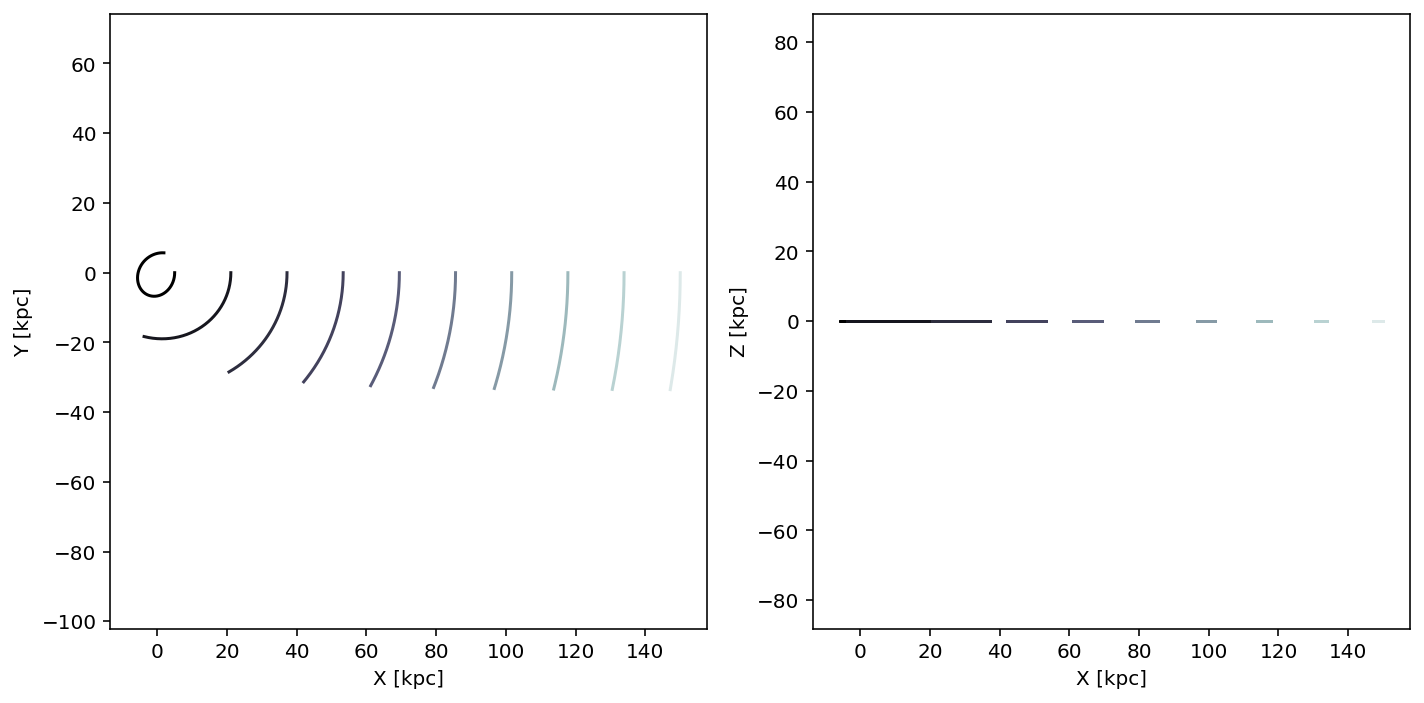

In [14]:
# set up figure
fig, ax = plt.subplots(1,2,figsize=(10,5))

plt.sca(ax[0])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

# plot different orbits in different colors
# you can look up available colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# the range in colormap is 0 to 1, so for the viridis colormap, you get the purple color by mpl.cm.viridis(0), 
# the greenish color by mpl.cm.viridis(0.5), and yellow by mpl.cm.viridis(1)
for i in range(N):
    plt.sca(ax[0])
    plt.plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 
    
    plt.sca(ax[1])
    plt.plot(orbit.pos.x[:,i], orbit.pos.z[:,i], '-', color=mpl.cm.bone(i/N))

plt.tight_layout()

(-150.0, 150.0)

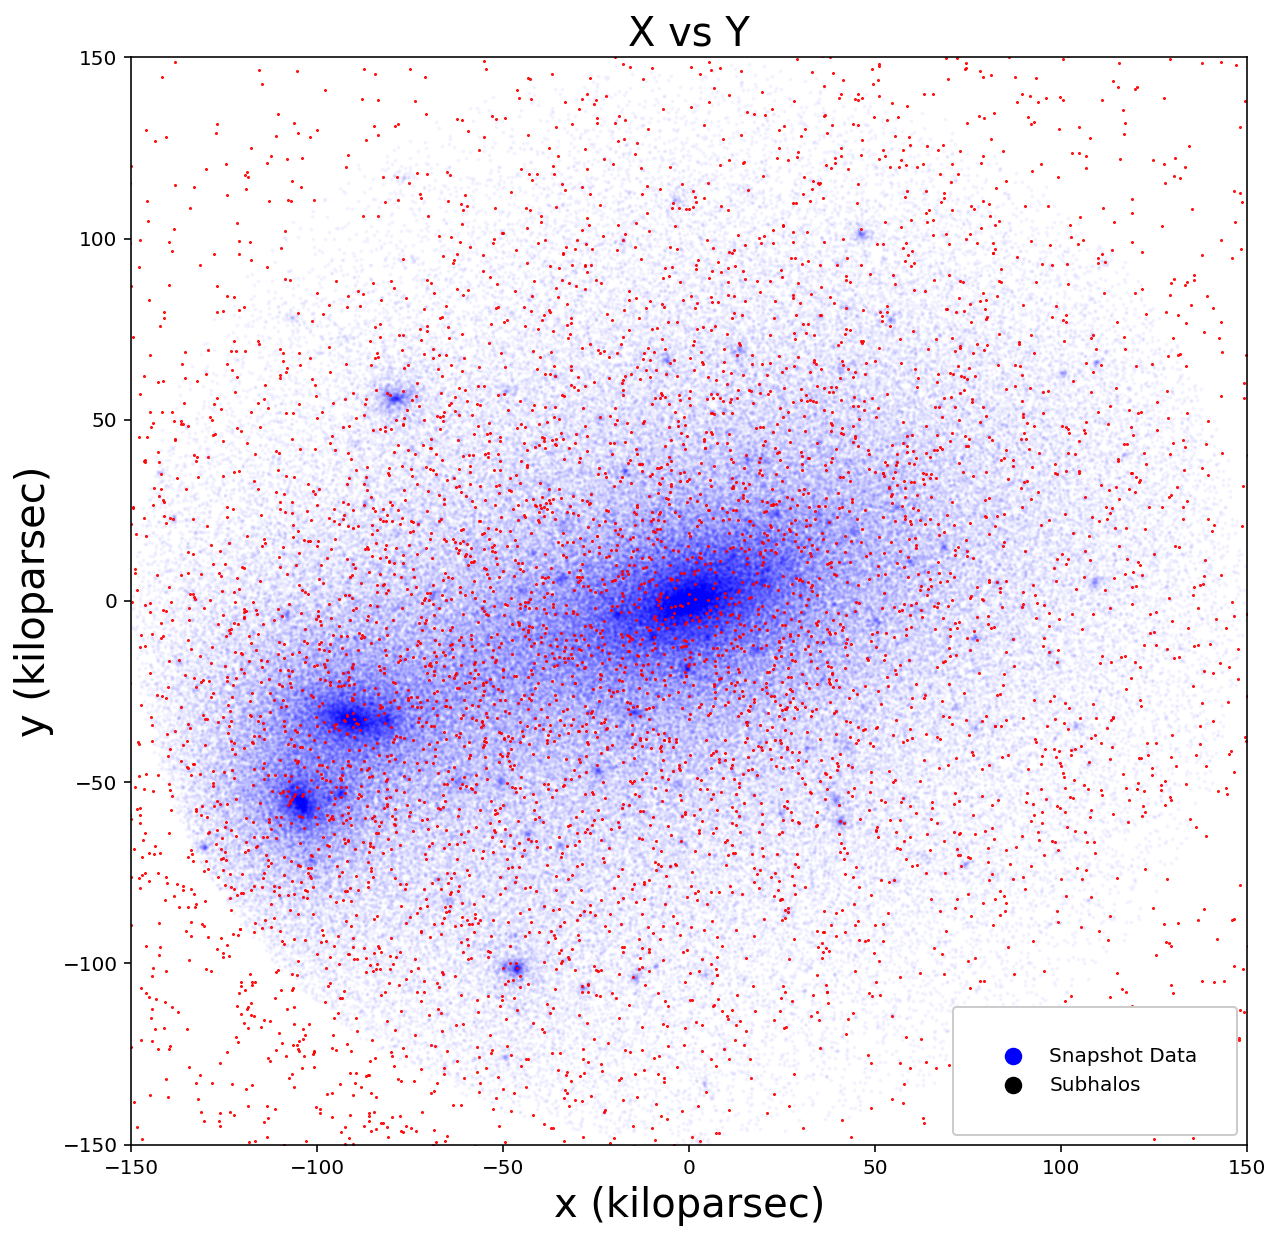

In [15]:
ind_massive = (subhalos_z0['mvir'] > 10**6) & (subhalos_z0['mvir'] < 10**8)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
plt.plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
plt.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
plt.xlabel('x (kiloparsec)', fontsize=20)
plt.ylabel('y (kiloparsec)', fontsize=20)
plt.title('X vs Y', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
plt.xlim(-150,150)
plt.ylim(-150,150)


(-40.0, -20.0)

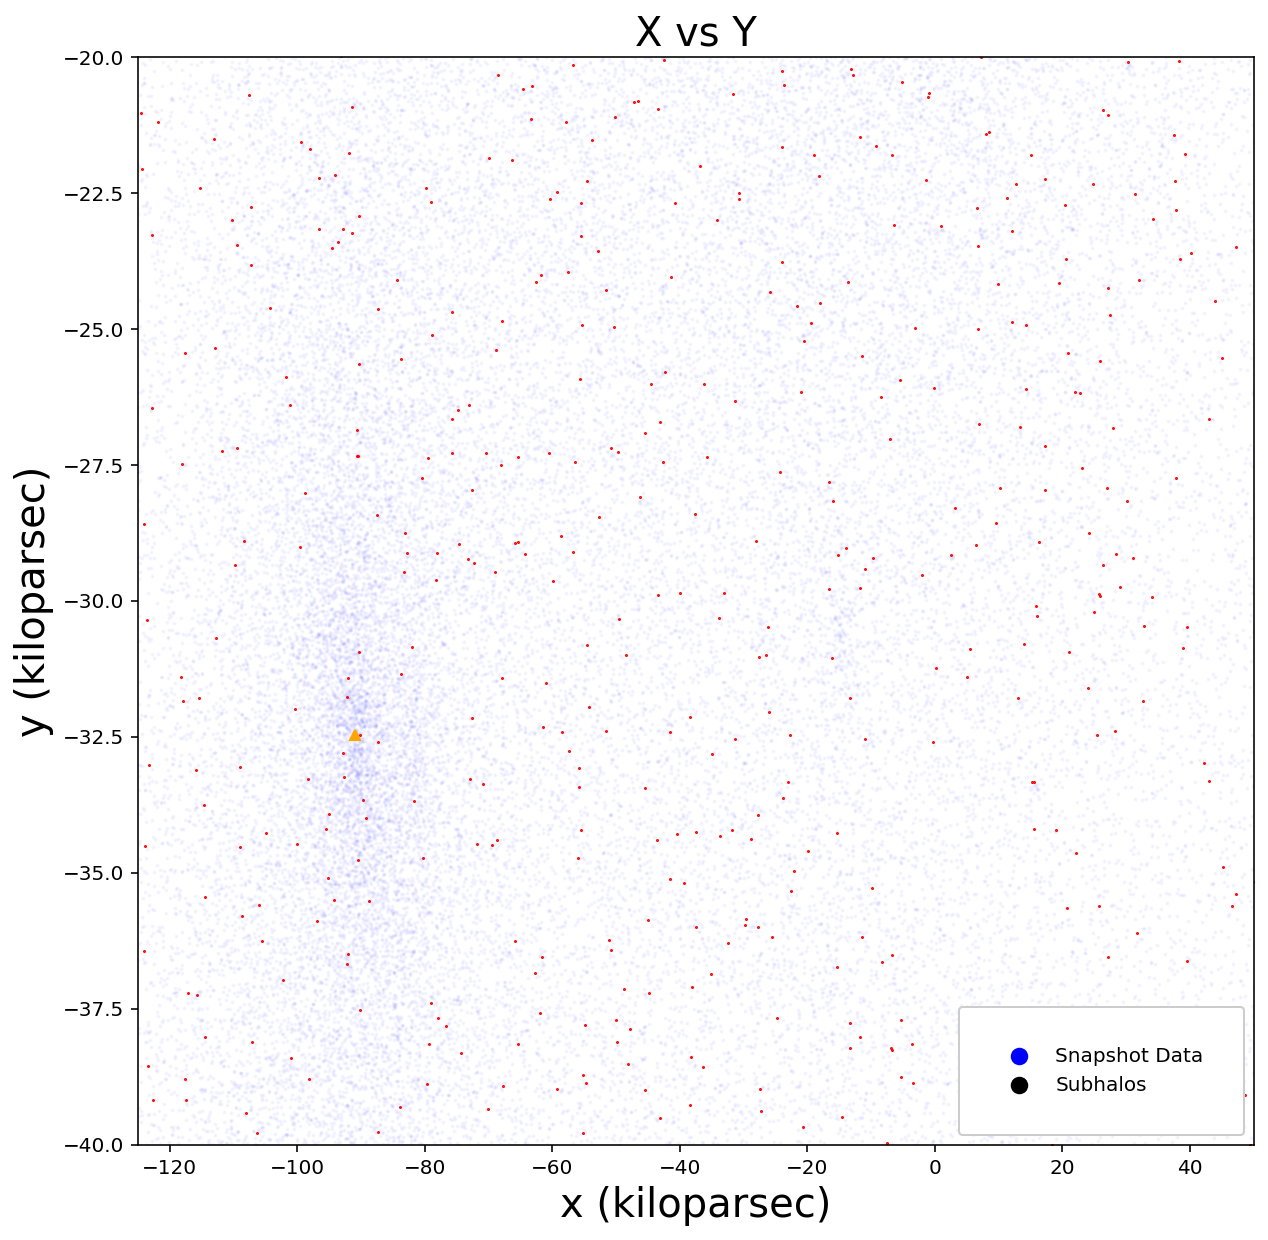

In [16]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
plt.plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
plt.plot(LMC_analog['x'],LMC_analog['y'],color='orange',marker='^',ms=5)
plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
plt.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
plt.xlabel('x (kiloparsec)', fontsize=20)
plt.ylabel('y (kiloparsec)', fontsize=20)
plt.title('X vs Y', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
plt.xlim(-125,50)
plt.ylim(-40,-20)

In [34]:
N=20
x = np.linspace(-120,40,N)*u.kpc
y = np.linspace(-20,60,N)*u.kpc
z = np.zeros(N)*u.kpc
vx = np.zeros(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 300
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    plt.plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    plt.plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
plt.plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
plt.plot(LMC_analog['x'],LMC_analog['y'],color='orange',marker='^',ms=5)
plt.plot(1000,10000, marker='o', color='blue', ms=60, label='DM Particles')
plt.plot(1000,10000, marker='o', color='red', ms=60, label='Subhalos')
plt.plot(1000,10000, marker='^', color='orange', ms=60, label='LMC')
plt.xlabel('x (kiloparsec)', fontsize=20)
plt.ylabel('y (kiloparsec)', fontsize=20)
plt.title('X vs Y', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')


<IPython.core.display.Javascript object>


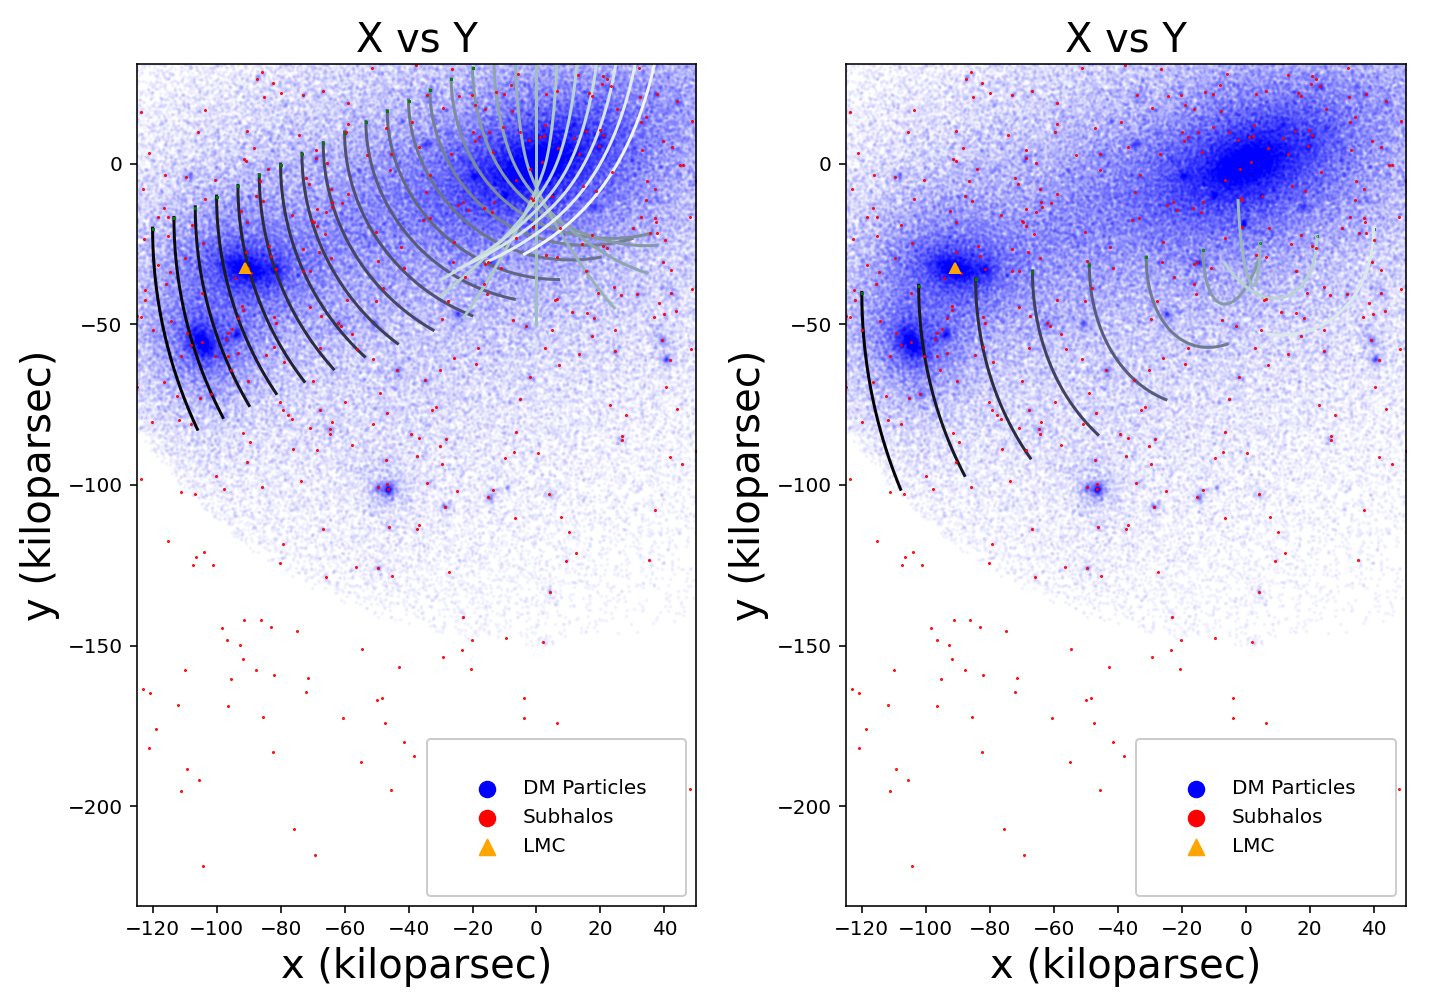

In [44]:
fig, ax = plt.subplots(1,2,figsize=(10,7))

plt.sca(ax[0])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 25
x = np.linspace(-120,40,N)*u.kpc
y = np.linspace(-20,60,N)*u.kpc
z = np.zeros(N)*u.kpc
vx = np.zeros(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 300
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[0].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[0].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[0].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[0].plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
ax[0].plot(LMC_analog['x'],LMC_analog['y'],color='orange',marker='^',ms=5)
ax[0].scatter(1000,10000, marker='o', color='blue', s=60, label='DM Particles')
ax[0].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[0].scatter(1000,10000, marker='^', color='orange', s=60, label='LMC')
ax[0].set_xlabel('x (kiloparsec)', fontsize=20)
ax[0].set_ylabel('y (kiloparsec)', fontsize=20)
ax[0].set_title('X vs Y', fontsize=20)
ax[0].legend(loc='best')
ax[0].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[0].set_xlim(-125,50)
ax[0].set_ylim(-150,-50)



plt.sca(ax[1])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 10
x = np.linspace(-120,40,N)*u.kpc
y = np.linspace(-40,-20,N)*u.kpc
z = np.zeros(N)*u.kpc
vx = np.zeros(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 300
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[1].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[1].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[1].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[1].plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
ax[1].plot(LMC_analog['x'],LMC_analog['y'],color='orange',marker='^',ms=5)
ax[1].scatter(1000,10000, marker='o', color='blue', s=60, label='DM Particles')
ax[1].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[1].scatter(1000,10000, marker='^', color='orange', s=60, label='LMC')
ax[1].set_xlabel('x (kiloparsec)', fontsize=20)
ax[1].set_ylabel('y (kiloparsec)', fontsize=20)
ax[1].set_title('X vs Y', fontsize=20)
ax[1].legend(loc='best')
ax[1].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[1].set_xlim(-125,50)
ax[1].set_ylim(-150,-50)


plt.tight_layout()   

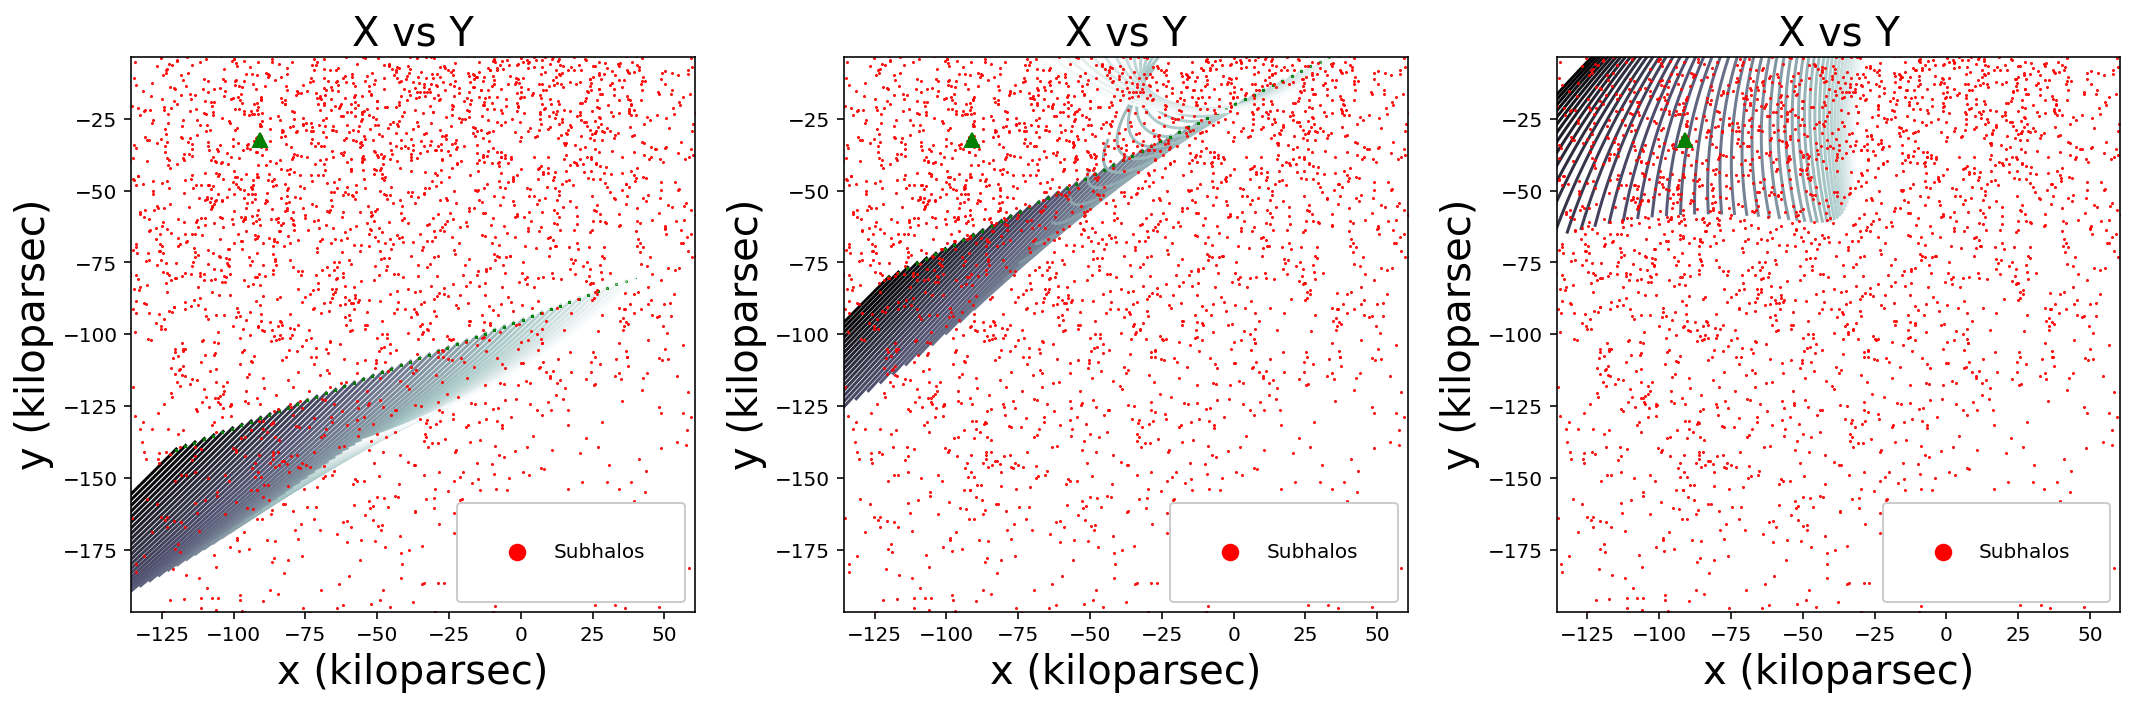

In [18]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(-140,-80,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 400
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[0].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[0].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[0].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[0].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[0].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[0].set_xlabel('x (kiloparsec)', fontsize=20)
ax[0].set_ylabel('y (kiloparsec)', fontsize=20)
ax[0].set_title('X vs Y', fontsize=20)
ax[0].legend(loc='best')
ax[0].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[0].set_xlim(-125,50)
ax[0].set_ylim(-150,-50)

plt.sca(ax[1])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(-80,0,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 400
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[1].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[1].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[1].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[1].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[1].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[1].set_xlabel('x (kiloparsec)', fontsize=20)
ax[1].set_ylabel('y (kiloparsec)', fontsize=20)
ax[1].set_title('X vs Y', fontsize=20)
ax[1].legend(loc='best')
ax[1].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[1].set_xlim(-125,50)
ax[1].set_ylim(-150,-50)



plt.sca(ax[2])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(0,100,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 400
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[2].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[2].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[2].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[2].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[2].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[2].set_xlabel('x (kiloparsec)', fontsize=20)
ax[2].set_ylabel('y (kiloparsec)', fontsize=20)
ax[2].set_title('X vs Y', fontsize=20)
ax[2].legend(loc='best')
ax[2].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[2].set_xlim(-125,50)
ax[2].set_ylim(-150,-50)


plt.tight_layout()   

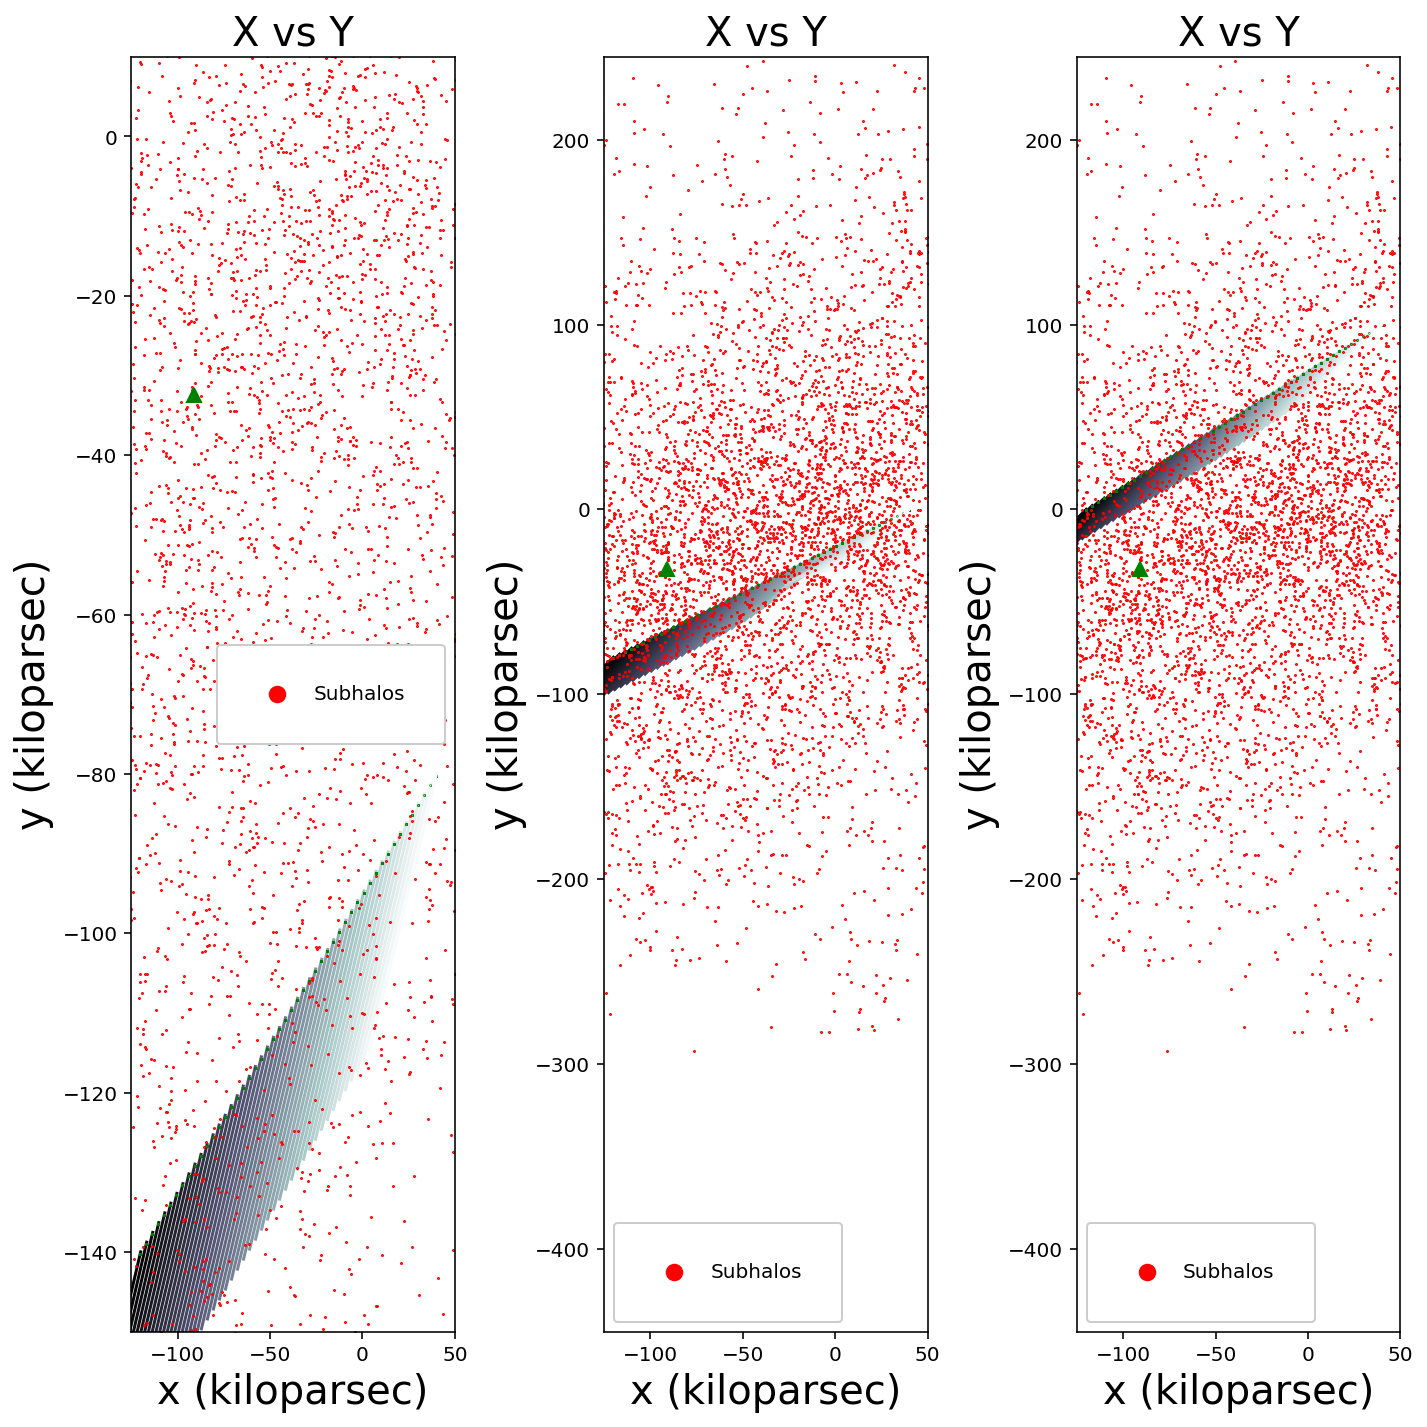

In [19]:
fig, ax = plt.subplots(1,3,figsize=(10,10))

plt.sca(ax[0])
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(-140,-80,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=LMC_analog['mvir']*h*u.Msun, r_s=LMC_analog['rs']*h*u.kpc, units=galactic))

Nstep = 160
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[0].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[0].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[0].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[0].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[0].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[0].set_xlabel('x (kiloparsec)', fontsize=20)
ax[0].set_ylabel('y (kiloparsec)', fontsize=20)
ax[0].set_title('X vs Y', fontsize=20)
ax[0].legend(loc='best')
ax[0].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[0].set_xlim(-125,50)
ax[0].set_ylim(-150,10)

plt.sca(ax[1])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(-80,0,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=LMC_analog['mvir']*h*u.Msun, r_s=LMC_analog['rs']*h*u.kpc, units=galactic))

Nstep = 160
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[1].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[1].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[1].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[1].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[1].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[1].set_xlabel('x (kiloparsec)', fontsize=20)
ax[1].set_ylabel('y (kiloparsec)', fontsize=20)
ax[1].set_title('X vs Y', fontsize=20)
ax[1].legend(loc='best')
ax[1].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[1].set_xlim(-125,50)
ax[1].set_ylim(-150,-50)



plt.sca(ax[2])
plt.gca().set_aspect('equal', adjustable='datalim')
N = 50
x = np.linspace(-120,40,N)*u.kpc #changing these
y = np.linspace(0,100,N)*u.kpc #changing these
z = np.zeros(N)*u.kpc
vx = np.ones(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=LMC_analog['mvir']*h*u.Msun, r_s=LMC_analog['rs']*h*u.kpc, units=galactic))

Nstep = 160
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    ax[2].plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    ax[2].plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

ax[2].plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
ax[2].plot(LMC_analog['x'],LMC_analog['y'],color='green',marker='^',ms=7)
ax[2].scatter(1000,10000, marker='o', color='red', s=60, label='Subhalos')
ax[2].set_xlabel('x (kiloparsec)', fontsize=20)
ax[2].set_ylabel('y (kiloparsec)', fontsize=20)
ax[2].set_title('X vs Y', fontsize=20)
ax[2].legend(loc='best')
ax[2].legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax[2].set_xlim(-125,50)
ax[2].set_ylim(-150,-50)


plt.tight_layout()   

<ipython-input-20-73a4e55d0a5d>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive],edgecolors='none',


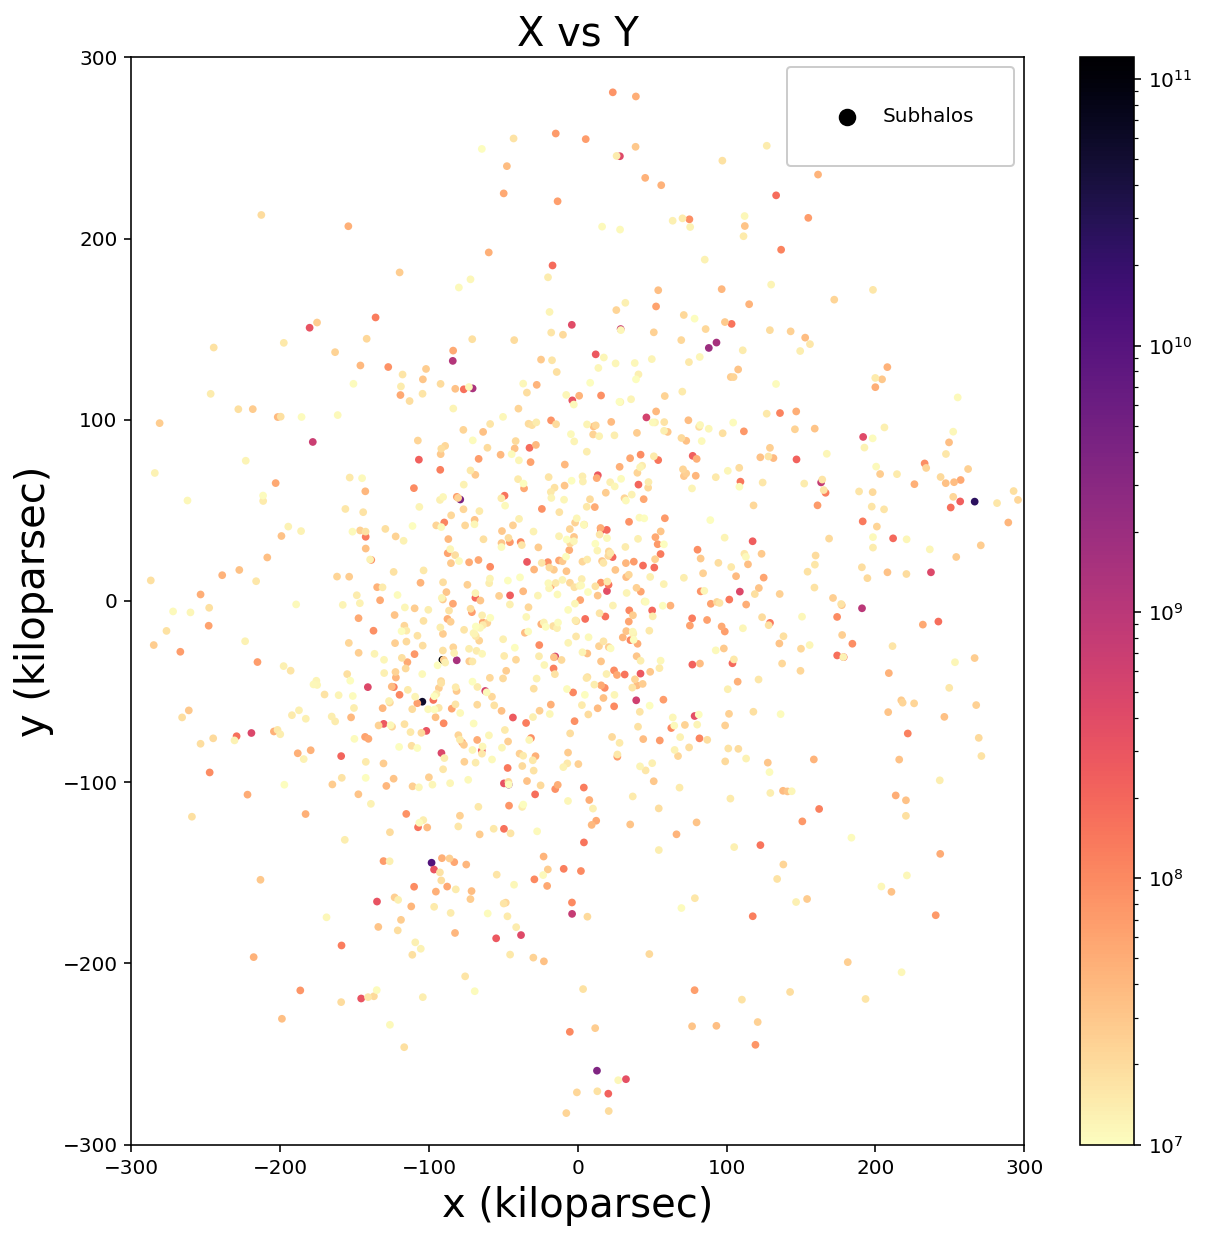

In [20]:
ind_massive = (subhalos_z0['mvir'] > 10**7) #& (subhalos_z0['mvir'] < 10**8)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
#plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
im = plt.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive],edgecolors='none',
            s=15,c=subhalos_z0['mvir'][ind_massive],norm=mpl.colors.LogNorm(), vmin=10**7, cmap='magma_r')
#plt.plot(t['x'],t['y'],color='blue',marker='o', ms=1,ls='None', alpha = 0.03, zorder=0)
#plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
plt.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
plt.xlabel('x (kiloparsec)', fontsize=20)
plt.ylabel('y (kiloparsec)', fontsize=20)
plt.title('X vs Y', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
plt.xlim(-300,300)
plt.ylim(-300,300)
plt.colorbar(im)


<ipython-input-21-3f12277e1b81>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',


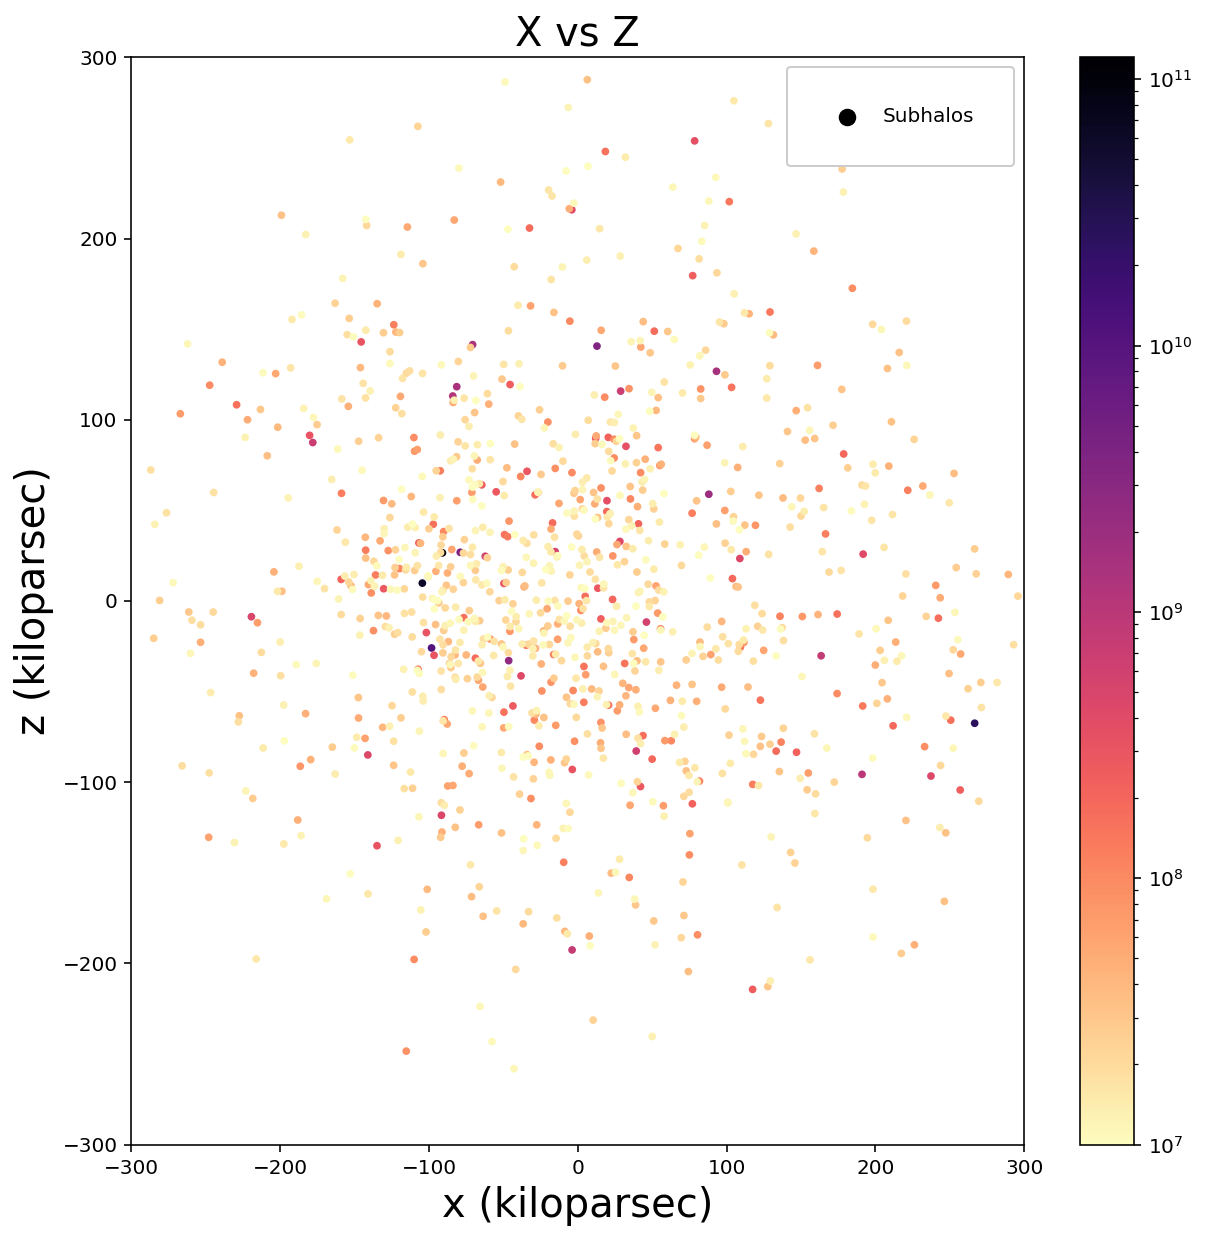

In [21]:
ind_massive = (subhalos_z0['mvir'] > 10**7) #& (subhalos_z0['mvir'] < 10**8)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
#plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
im = plt.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',
            s=15,c=subhalos_z0['mvir'][ind_massive],norm=mpl.colors.LogNorm(), vmin=10**7, cmap='magma_r')
#plt.plot(t['x'],t['y'],color='blue',marker='o', ms=1,ls='None', alpha = 0.03, zorder=0)
#plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
plt.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
plt.xlabel('x (kiloparsec)', fontsize=20)
plt.ylabel('z (kiloparsec)', fontsize=20)
plt.title('X vs Z', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
plt.xlim(-300,300)
plt.ylim(-300,300)
plt.colorbar(im)


<ipython-input-22-14a7bf6b4e5c>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.scatter(subhalos_z0['y'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',


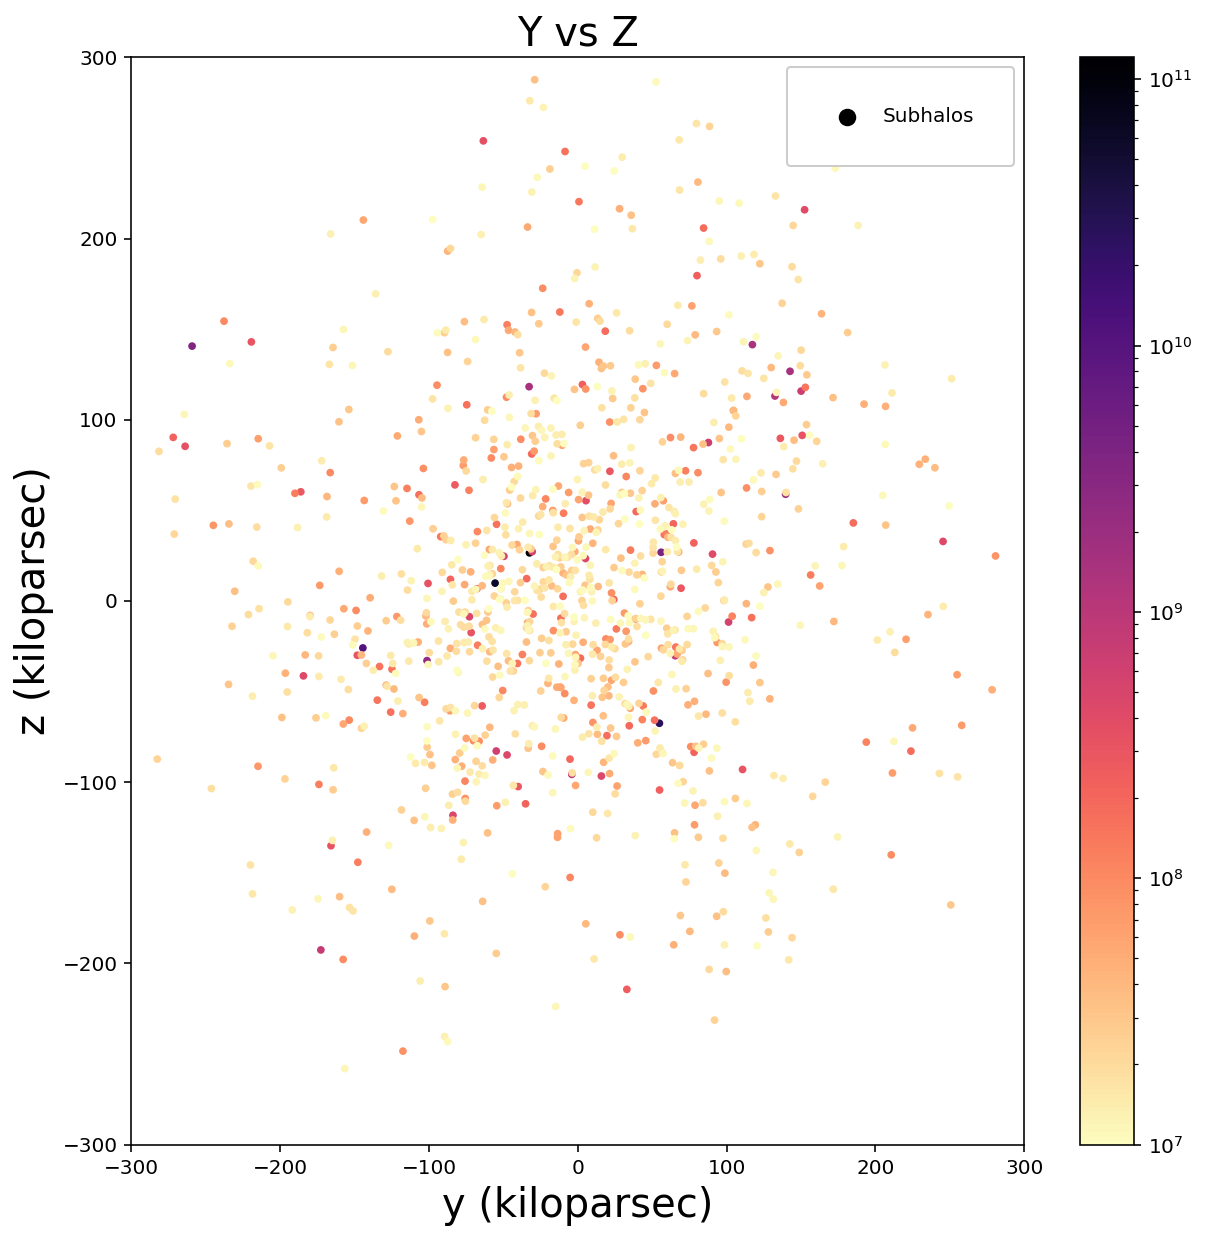

In [22]:
ind_massive = (subhalos_z0['mvir'] > 10**7) #& (subhalos_z0['mvir'] < 10**8)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
#plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
im = plt.scatter(subhalos_z0['y'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',
            s=15,c=subhalos_z0['mvir'][ind_massive],norm=mpl.colors.LogNorm(), vmin=10**7, cmap='magma_r')
#plt.plot(t['x'],t['y'],color='blue',marker='o', ms=1,ls='None', alpha = 0.03, zorder=0)
#plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
plt.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
plt.xlabel('y (kiloparsec)', fontsize=20)
plt.ylabel('z (kiloparsec)', fontsize=20)
plt.title('Y vs Z', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
plt.xlim(-300,300)
plt.ylim(-300,300)
plt.colorbar(im)


In [23]:
%matplotlib notebook

In [24]:
ind_massive = (subhalos_z0['mvir'] > 10**7) #& (subhalos_z0['mvir'] < 10**8)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

#plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
im = ax.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',
            s=15,c=subhalos_z0['mvir'][ind_massive],norm=mpl.colors.LogNorm(), vmin=10**7,vmax=10**10, cmap='magma_r')
#plt.plot(t['x'],t['y'],color='blue',marker='o', ms=1,ls='None', alpha = 0.03, zorder=0)
#plt.scatter(1000,10000, marker='o', color='blue', s=60, label='Snapshot Data')
ax.scatter(LMC_analog['x'],LMC_analog['y'],LMC_analog['z'],color='green',marker='*',s=75)
ax.scatter(1000,10000, marker='o', color='black', s=60, label='Subhalos')
ax.set_xlabel('x (kiloparsec)', fontsize=20)
ax.set_ylabel('y (kiloparsec)', fontsize=20)
ax.set_zlabel('z (kiloparsec)', fontsize=20)
ax.set_title('X vs Y vs Z', fontsize=20)
plt.legend(loc='best')
plt.legend(facecolor='white', framealpha=1, borderpad=2, loc='best')
ax.set_xlim(-300,300)
ax.set_ylim(-300,300)
plt.colorbar(im)

<IPython.core.display.Javascript object>

<ipython-input-24-34549c9de4d6>:10: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.scatter(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], subhalos_z0['z'][ind_massive],edgecolors='none',


In [25]:
gala streams package 
# ask silvia about it 
Gala 
fix milky way and then say that the LMC is movable 


SyntaxError: invalid syntax (<ipython-input-25-fdc55bf63a16>, line 1)

In [38]:
N=20
x = np.linspace(-120,40,N)*u.kpc
y = np.linspace(-20,60,N)*u.kpc
z = np.zeros(N)*u.kpc
vx = np.zeros(N)*220*u.km/u.s
vy = np.ones(N)*220*u.km/u.s
vz = np.zeros(N)*u.km/u.s
c = coord.Galactocentric(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz)
w0 = gd.PhaseSpacePosition(c.cartesian)
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']*h*u.Msun, r_s=MW_analog['rs']*h*u.kpc, units=galactic))

Nstep = 300
dt = -1*u.Myr
orbit = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep)

for i in range(N):
    plt.plot(orbit.pos.x[1], orbit.pos.y[1], '.g', ms=0.5)
    plt.plot(orbit.pos.x[:,i], orbit.pos.y[:,i], '-', color=mpl.cm.bone(i/N)) #i/N gives you a fraction that determines different colors 

plt.plot(subhalos_z0['x'][ind_massive], subhalos_z0['y'][ind_massive], '.r', ms = 1)
plt.plot(t['x'],t['y'],color='blue',marker='o',ms=1,ls='None', alpha = 0.03, zorder=0)
plt.plot(LMC_analog['x'],LMC_analog['y'],color='orange',marker='^',ms=5)
plt.plot(1000,10000, marker='o', color='blue', ms=60, label='DM Particles')
plt.plot(1000,10000, marker='o', color='red', ms=60, label='Subhalos')
plt.plot(1000,10000, marker='^', color='orange', ms=60, label='LMC')
plt.xlabel('x (kiloparsec)')
plt.ylabel('y (kiloparsec)')#, fontsize=20)
plt.title('X vs Y')#, fontsize=20)




Text(0.5, 1.0, 'X vs Y')